# GOAL
The goal is to build a time series model to predict unit sales

#### Hypothesis.
#####  Sales are positively affected by holidays.
##### Sales are affected negatively when oil prices go up.

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import waterfall_chart

In [2]:
# Loading up the files
holiday = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv')
submission = pd.read_csv('sample_submission.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
transactions = pd.read_csv('transactions.csv')

### Questions
* Which year had highest number of transaction?
* Which year had the most sales?
* What is the impact of oil prices on sales?                                                              
* Which location has the highest number of stores 
* Which city has the highest amount of sales?   
* Which family (product) sales the most?  
* Which store had the most sales?
* Which store had the most transactions?
* Which item sells most on holidays?

## CLEANING THE TRAIN DATASET.

In [3]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [4]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [5]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [7]:
train.family.nunique()

33

In [8]:
# Checking for range of data
train.date.min(), train.date.max()

('2013-01-01', '2017-08-15')

In [9]:
train['date'] = pd.to_datetime(train['date']).dt.date

In [10]:
# Checking the date range.
train.date.min(), train.date.max()

(datetime.date(2013, 1, 1), datetime.date(2017, 8, 15))

### Checking the completeness of the dates
Checking for the difference between the max and the min dates will help us know if there are any missing dates. From the outcome we can tell that the data is supose to give us a total of 1688 days.

In [11]:
# Checking the completeness of the date.
date_difference = (train['date'].max() - train['date'].min())

In [12]:
# Expected number of days from our data set.
date_difference.days + 1

1688

In [13]:
# Checking for Actual number of days from dataset.
train['date'].nunique()

1684

Looking at the number we got for the actual dates, it is clear that there's a shortage of 4 days which indicates that there are 4 dates missing in our original dataset.

**Showing dates the are missing**

In [14]:
# Viewing all the dates within the dataset.
expected_dates = pd.date_range(start = train['date'].min(), end = train['date'].max())
expected_dates

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [15]:
# Extracting the missing date
set(expected_dates.date) - set(train['date'].unique())

{datetime.date(2013, 12, 25),
 datetime.date(2014, 12, 25),
 datetime.date(2015, 12, 25),
 datetime.date(2016, 12, 25)}

In [16]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


From the output we can clearly see that all the years have 25th of December missing.

## IMPUTING THE MISSING VALUES IN THE TRAIN DATA SET.
Since this a time series problem there cannot be any missing date in the data. With this the missing data must be imputed in the data to complete it for better analysis and modeling.

In [17]:
from itertools import product

In [18]:
# Extracting the unique values of store_nbr, family and the missing dates
missing_dates = set(expected_dates.date) - set(train['date'].unique())
unique_stores = train.store_nbr.unique()
unique_families = train.family.unique()

In [19]:
# Combining the unique values into a list and asigning it to a variable.
missing_data = list(product(missing_dates, unique_stores, unique_families))
missing_data

[(datetime.date(2016, 12, 25), 1, 'AUTOMOTIVE'),
 (datetime.date(2016, 12, 25), 1, 'BABY CARE'),
 (datetime.date(2016, 12, 25), 1, 'BEAUTY'),
 (datetime.date(2016, 12, 25), 1, 'BEVERAGES'),
 (datetime.date(2016, 12, 25), 1, 'BOOKS'),
 (datetime.date(2016, 12, 25), 1, 'BREAD/BAKERY'),
 (datetime.date(2016, 12, 25), 1, 'CELEBRATION'),
 (datetime.date(2016, 12, 25), 1, 'CLEANING'),
 (datetime.date(2016, 12, 25), 1, 'DAIRY'),
 (datetime.date(2016, 12, 25), 1, 'DELI'),
 (datetime.date(2016, 12, 25), 1, 'EGGS'),
 (datetime.date(2016, 12, 25), 1, 'FROZEN FOODS'),
 (datetime.date(2016, 12, 25), 1, 'GROCERY I'),
 (datetime.date(2016, 12, 25), 1, 'GROCERY II'),
 (datetime.date(2016, 12, 25), 1, 'HARDWARE'),
 (datetime.date(2016, 12, 25), 1, 'HOME AND KITCHEN I'),
 (datetime.date(2016, 12, 25), 1, 'HOME AND KITCHEN II'),
 (datetime.date(2016, 12, 25), 1, 'HOME APPLIANCES'),
 (datetime.date(2016, 12, 25), 1, 'HOME CARE'),
 (datetime.date(2016, 12, 25), 1, 'LADIESWEAR'),
 (datetime.date(2016, 12, 2

In [20]:
# Converting the missing data extract into a DataFrame.
missing_data_df = pd.DataFrame(missing_data, columns = ['date', 'store_nbr', 'family'])
missing_data_df.head()

,date,store_nbr,family
0,2016-12-25,1,AUTOMOTIVE
1,2016-12-25,1,BABY CARE
2,2016-12-25,1,BEAUTY
3,2016-12-25,1,BEVERAGES
4,2016-12-25,1,BOOKS


In [21]:
# Merging the missing_data with the train data.
new_train = pd.concat([train, missing_data_df], ignore_index = False)
new_train

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0
4,4.0,2013-01-01,1,BOOKS,0.0,0.0
...,...,...,...,...,...,...
7123,NaN,2014-12-25,9,POULTRY,NaN,NaN
7124,NaN,2014-12-25,9,PREPARED FOODS,NaN,NaN
7125,NaN,2014-12-25,9,PRODUCE,NaN,NaN
7126,NaN,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,NaN,NaN


In [22]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3008016 entries, 0 to 7127
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           float64
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 160.6+ MB


### **Filling missing values in the new train dataset.**

We can observe from our new_train dataset that we have have null values in the 'sales' and 'onpromotion' column. Since all our missing values were on the 25th of December, we can assume that the stores didn't open and for that matter there was no sales on that day. Similarly, the same applies to the 'onpromotion' column, if its a holiday, then there can't be a promotion runing.

With this all null values in the 'sales' and 'onpromotion' will be filled out zeros to indicate no sales and no promotions running.

In [23]:
# Filling missing values with with zeros
new_train = new_train.replace(to_replace = np.nan, value = 0)
new_train

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0
4,4.0,2013-01-01,1,BOOKS,0.0,0.0
...,...,...,...,...,...,...
7123,0.0,2014-12-25,9,POULTRY,0.0,0.0
7124,0.0,2014-12-25,9,PREPARED FOODS,0.0,0.0
7125,0.0,2014-12-25,9,PRODUCE,0.0,0.0
7126,0.0,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0


In [24]:
new_train.sales.nunique()

379610

In [25]:
new_train.onpromotion.nunique()

362

In [26]:
new_train

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0
4,4.0,2013-01-01,1,BOOKS,0.0,0.0
...,...,...,...,...,...,...
7123,0.0,2014-12-25,9,POULTRY,0.0,0.0
7124,0.0,2014-12-25,9,PREPARED FOODS,0.0,0.0
7125,0.0,2014-12-25,9,PRODUCE,0.0,0.0
7126,0.0,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0


#### PROCESSING THE STORES DATA SET.

In [27]:
#Loading the stores data set
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


Since the data set containing the location of the stores are separate we would have to merge it with the new train dataset in other to get a clear picture of the location with most stores and location. 

In doing this, we would have to match every store number in the new train dataset to its location (city) in the 'stores' dataset.

In [28]:
new_train['city'] = np.nan
new_train.head()

,id,date,store_nbr,family,sales,onpromotion,city
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,NaN
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,NaN
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,NaN
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,NaN
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,NaN


In [29]:
new_train['city'] = new_train['store_nbr'].map({1:'Quito', 2:'Quito', 3:'Quito', 4:'Quito', 6:'Quito', 7:'Quito', 8:'Quito',
                                                9:'Quito', 10:'Quito', 17:'Quito', 18:'Quito', 20:'Quito', 44:'Quito', 45:'Quito',
                                               46:'Quito', 46:'Quito', 47:'Quito', 48:'Quito', 49:'Quito', 5:'Santo Domingo', 16:'Santo Domingo',
                                               21:'Santo Domingo', 11:'Cayambe', 12:'Latacunga', 13:'Latacunga', 14:'Riobamba',
                                               15:'Ibarra', 19:'Guaranda', 22:'Puyo', 23:'Ambato', 50:'Ambato', 24:'Guayaquil',
                                               26:'Guayaquil', 28:'Guayaquil', 29:'Guayaquil', 30:'Guayaquil', 32:'Guayaquil',
                                               34:'Guayaquil', 51:'Guayaquil', 25:'Salinas', 27:'Daule', 31:'Babahoyo', 33:'Quevedo',
                                               35:'Playas', 36:'Libertad', 37:'Cuenca', 39:'Cuenca', 42:'Cuenca', 38:'Loja',
                                               40:'Machala', 41:'Machala', 43:'Esmeraldas', 52:'Manta', 53:'Manta', 54:'El Carmen'})

new_train.head()


,id,date,store_nbr,family,sales,onpromotion,city
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito


In [30]:
# Checking for null values in the 'city' column to confirm the results.
new_train.city.isnull().sum()

0

In [31]:
new_train['year'] = pd.to_datetime(new_train['date']).dt.year
new_train['month'] = pd.to_datetime(new_train['date']).dt.month
new_train['day'] = pd.to_datetime(new_train['date']).dt.day
new_train['week'] = pd.to_datetime(new_train['date']).dt.week

C:\Users\Bernard Ampomah\AppData\Local\Temp\ipykernel_14356\2314175517.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  new_train['week'] = pd.to_datetime(new_train['date']).dt.week


In [32]:
new_train

,id,date,store_nbr,family,sales,onpromotion,city,year,month,day,week
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,2013,1,1,1
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito,2013,1,1,1
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito,2013,1,1,1
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,2013,1,1,1
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
7123,0.0,2014-12-25,9,POULTRY,0.0,0.0,Quito,2014,12,25,52
7124,0.0,2014-12-25,9,PREPARED FOODS,0.0,0.0,Quito,2014,12,25,52
7125,0.0,2014-12-25,9,PRODUCE,0.0,0.0,Quito,2014,12,25,52
7126,0.0,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,Quito,2014,12,25,52


In [33]:
new_train['date'] = pd.to_datetime(new_train['date'])

### Question . 
Which location has the highest the number of stores and sales?

In [34]:
city_stores = pd.DataFrame(new_train.groupby('city')['store_nbr'].sum().sort_values(ascending = False).reset_index())
city_stores['store_nbr'] = city_stores['store_nbr'].apply(lambda x: math.ceil(x))
city_stores

,city,store_nbr
0,Quito,21390336
1,Guayaquil,14148816
2,Cuenca,6573072
3,Manta,5848920
4,Machala,4512024
5,Ambato,4066392
6,El Carmen,3008016
7,Esmeraldas,2395272
8,Santo Domingo,2339568
9,Loja,2116752


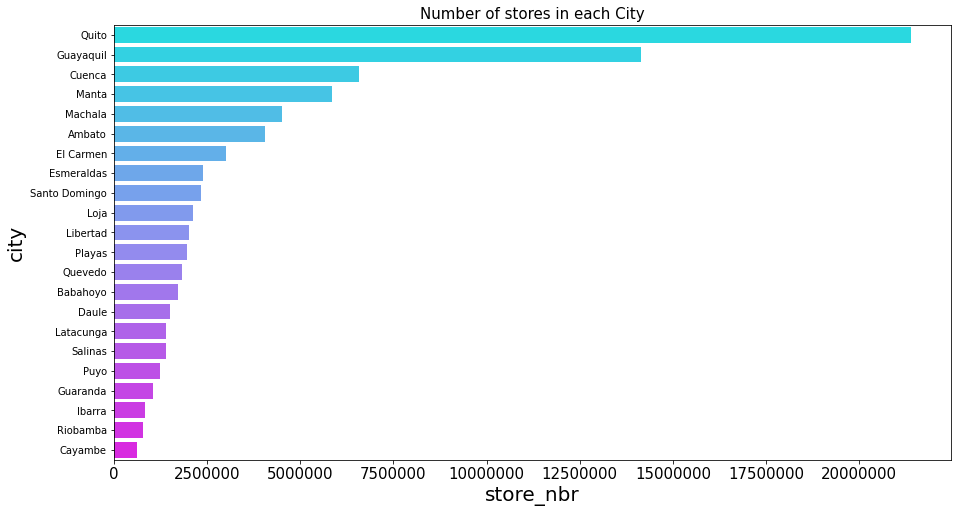

In [35]:
plt.figure(figsize = (15,8))
plt.title('Number of stores in each City',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('city', fontsize = 20)
plt.xlabel('number of stores', fontsize = 20)
sns.barplot(x = 'store_nbr', y = 'city', data  = city_stores,palette = 'cool')
plt.savefig('CityStores.png', dpi = 300)
plt.show()

**City with most sales**

This is to find out which city had the most sales regardless of the number of stores.

In [36]:
# Grouping the train data in terms on the location and the sales made.
city_sales = pd.DataFrame(new_train.groupby('city')['sales'].sum().sort_values(ascending = False).reset_index())
city_sales['sales'] = city_sales['sales'].apply(lambda x: math.ceil(x))
city_sales

,city,sales
0,Quito,556741837
1,Guayaquil,122967261
2,Cuenca,49168597
3,Ambato,40304402
4,Santo Domingo,35834324
5,Machala,33386797
6,Cayambe,28325559
7,Latacunga,21182264
8,Daule,19188022
9,Loja,18860000


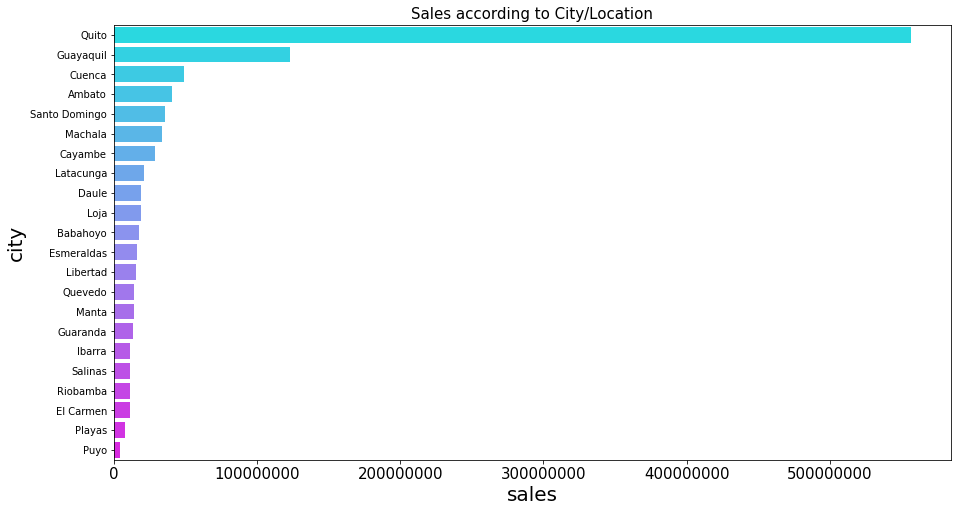

In [37]:
plt.figure(figsize = (15,8))
plt.title('Sales according to City/Location',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('sales',fontsize = 20)
plt.xlabel('city', fontsize = 20)
sns.barplot(x = 'sales', y = 'city', data  = city_sales,palette = 'cool')
plt.savefig('city_sales.png', dpi = 300)
plt.show()

### Question
What is the highest selling year, month, week and day?

### Year with most sales

In [38]:
year_sales = new_train.groupby(['year'], as_index = False)['sales'].sum()
year_sales['sales'] = year_sales['sales'].apply(lambda x: math.ceil(x))
year_sales

,year,sales
0,2013,140419014
1,2014,209474247
2,2015,240880101
3,2016,288654523
4,2017,194217069


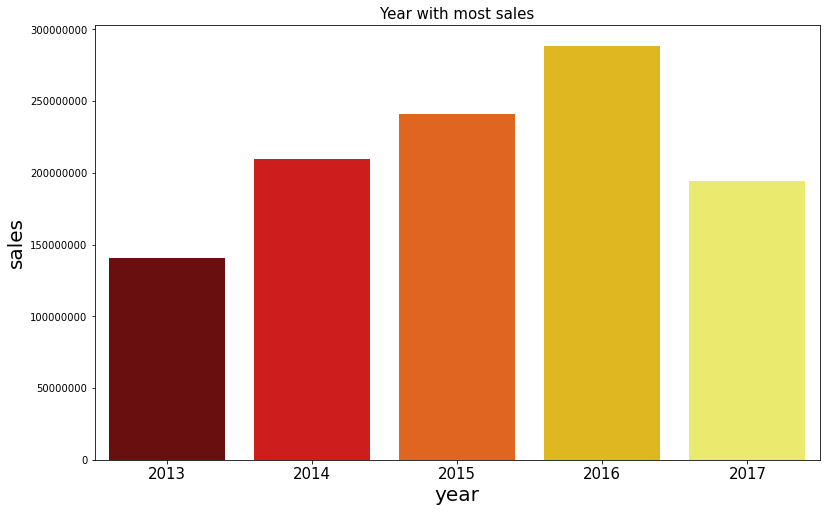

In [39]:
plt.figure(figsize = (13,8))
plt.title('Year with most sales',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('year',fontsize = 20)
plt.xlabel('sales', fontsize = 20)
sns.barplot(x = 'year', y = 'sales', data  = year_sales,palette = 'hot')
plt.savefig('yearsales.png', dpi = 300)
plt.show()

### Month with most sales

In [40]:
monthly_sales = pd.DataFrame(new_train.groupby('month')['sales'].sum().sort_values(ascending = False).reset_index())
monthly_sales['sales'] = monthly_sales['sales'].apply(lambda x: math.ceil(x))
monthly_sales

,month,sales
0,7,103363061
1,3,97228488
2,12,97027841
3,6,94516704
4,1,94442153
5,5,94399138
6,4,90668118
7,8,83472377
8,2,80637230
9,11,80335789


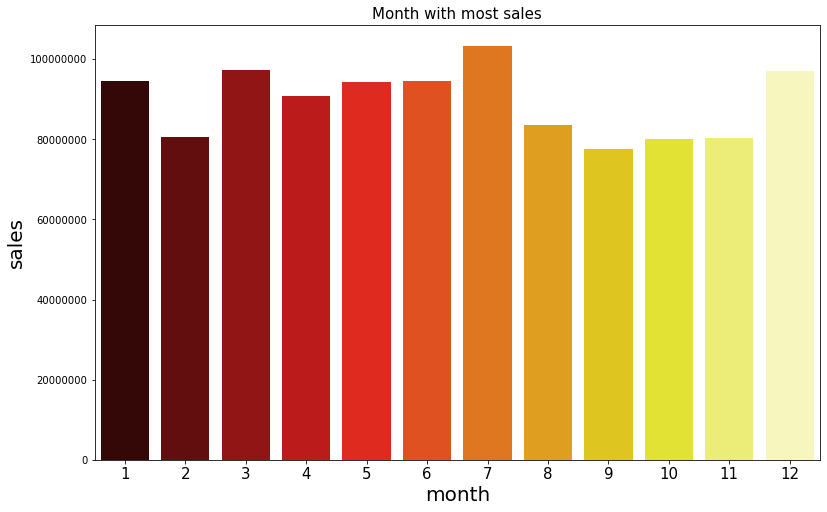

In [41]:
plt.figure(figsize = (13,8))
plt.title('Month with most sales',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('month',fontsize = 20)
plt.xlabel('sales', fontsize = 20)
sns.barplot(x = 'month', y = 'sales', data  = monthly_sales,palette = 'hot')
plt.savefig('monthly_sales.png', dpi = 300)
plt.show()

### Weeks with most sales

In [42]:
weekly_sales = pd.DataFrame(new_train.groupby('week')['sales'].sum().sort_values(ascending = False).reset_index().head(10))
weekly_sales['sales'] = weekly_sales['sales'].apply(lambda x: math.ceil(x))
weekly_sales

,week,sales
0,27,24970934
1,1,24786522
2,31,23962767
3,51,23188671
4,23,22988908
5,22,22934057
6,18,22775663
7,28,22574931
8,13,22484728
9,30,22426120


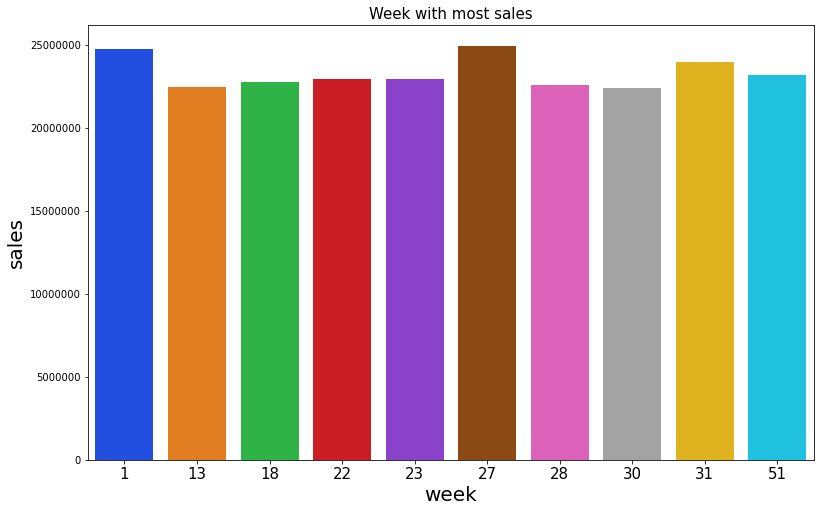

In [43]:
plt.figure(figsize = (13,8))
plt.title('Week with most sales',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('week',fontsize = 20)
plt.xlabel('sales', fontsize = 20)
sns.barplot(x = 'week', y = 'sales', data  = weekly_sales,palette = 'bright')
plt.savefig('weekly_sales.png', dpi = 300)
plt.show()

### Days with most sales

In [44]:
daily_sales = pd.DataFrame(new_train.groupby('day')['sales'].sum().sort_values(ascending = False).reset_index().head(10))
daily_sales['sales'] = daily_sales['sales'].apply(lambda x: math.ceil(x))
daily_sales

,day,sales
0,2,41634742
1,3,40132254
2,1,39874563
3,4,39198990
4,5,38295525
5,6,37228241
6,7,36339497
7,16,35479058
8,8,35134767
9,23,35056383


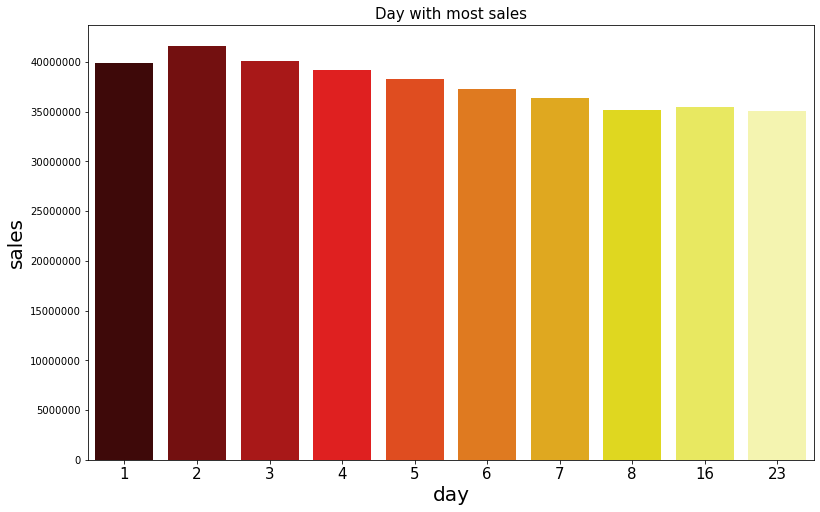

In [45]:
plt.figure(figsize = (13,8))
plt.title('Day with most sales',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('day',fontsize = 20)
plt.xlabel('sales', fontsize = 20)
sns.barplot(x = 'day', y = 'sales', data  = daily_sales,palette = 'hot')
plt.savefig('daily_sales.png', dpi = 300)
plt.show()

### Question 
Which year had highest number of transaction?

In [46]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [47]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [48]:
transactions['year'] = pd.to_datetime(transactions['date']).dt.year
transactions

,date,store_nbr,transactions,year
0,2013-01-01,25,770,2013
1,2013-01-02,1,2111,2013
2,2013-01-02,2,2358,2013
3,2013-01-02,3,3487,2013
4,2013-01-02,4,1922,2013
...,...,...,...,...
83483,2017-08-15,50,2804,2017
83484,2017-08-15,51,1573,2017
83485,2017-08-15,52,2255,2017
83486,2017-08-15,53,932,2017


In [49]:
transaction_number1 = transactions.groupby(['year'], as_index = False)['transactions'].sum()
transaction_number1['transactions'] = transaction_number1['transactions'].apply(lambda x: math.ceil(x))
transaction_number1

,year,transactions
0,2013,29107173
1,2014,30006929
2,2015,31312370
3,2016,31052337
4,2017,20000136


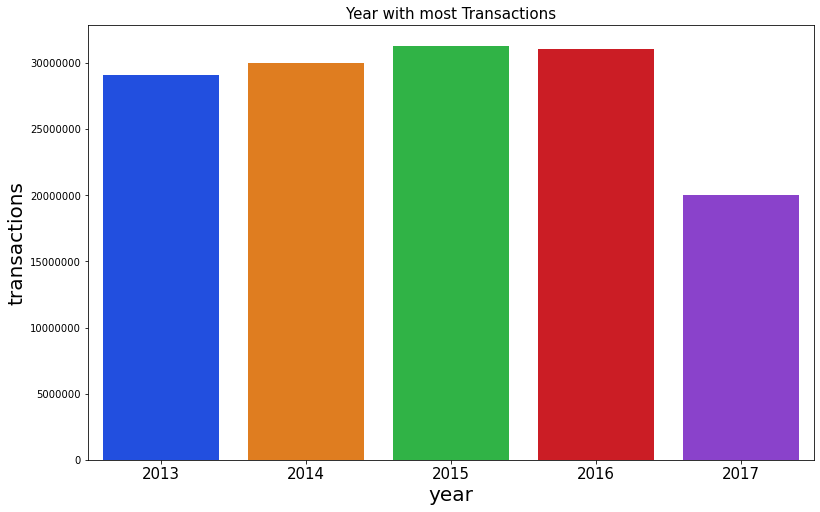

In [50]:
plt.figure(figsize = (13,8))
plt.title('Year with most Transactions',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('year',fontsize = 20)
plt.xlabel('transactions', fontsize = 20)
sns.barplot(x = 'year', y = 'transactions', data  = transaction_number1,palette = 'bright')
plt.savefig('transaction_number1.png', dpi = 300)
plt.show()

### Question
Which store had the most number of transactions

In [51]:
store_transaction = pd.DataFrame(transactions.groupby('store_nbr')['transactions'].sum().sort_values(ascending = False).reset_index().head(10))
store_transaction['transactions'] = store_transaction['transactions'].apply(lambda x: math.ceil(x))
store_transaction

,store_nbr,transactions
0,44,7273093
1,47,6535810
2,45,6201115
3,46,5990113
4,3,5366350
5,48,5107785
6,8,4637971
7,49,4574103
8,50,4384444
9,11,3972488


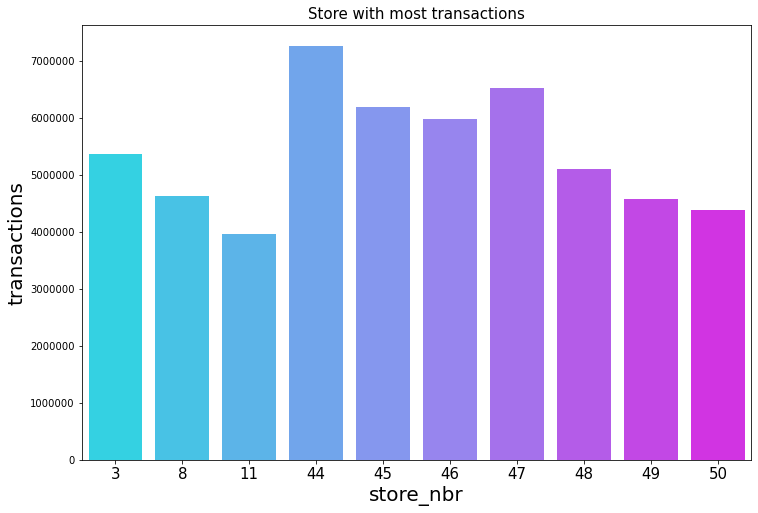

In [52]:
plt.figure(figsize = (12,8))
plt.title('Store with most transactions',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('store_nbr',fontsize = 20)
plt.xlabel('transactions', fontsize = 20)
sns.barplot(x = 'store_nbr', y = 'transactions', data  = store_transaction,palette = 'cool')
plt.savefig('store_transaction.png', dpi = 300)
plt.show()

### Question 
* Which store had the most sales

In [53]:
new_train

,id,date,store_nbr,family,sales,onpromotion,city,year,month,day,week
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,2013,1,1,1
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito,2013,1,1,1
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito,2013,1,1,1
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,2013,1,1,1
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
7123,0.0,2014-12-25,9,POULTRY,0.0,0.0,Quito,2014,12,25,52
7124,0.0,2014-12-25,9,PREPARED FOODS,0.0,0.0,Quito,2014,12,25,52
7125,0.0,2014-12-25,9,PRODUCE,0.0,0.0,Quito,2014,12,25,52
7126,0.0,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,Quito,2014,12,25,52


In [54]:
store_sales = pd.DataFrame(new_train.groupby('store_nbr')['sales'].sum().sort_values(ascending = False).reset_index().head(10))
store_sales['sales'] = store_sales['sales'].apply(lambda x: math.ceil(x))
store_sales

,store_nbr,sales
0,44,62087554
1,45,54498011
2,47,50948311
3,3,50481911
4,49,43420096
5,46,41896063
6,48,35933131
7,51,32911490
8,8,30494287
9,50,28653021


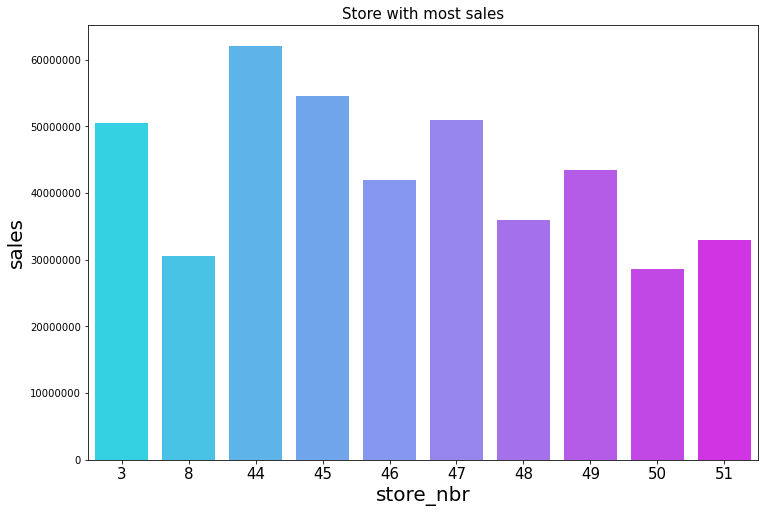

In [55]:
plt.figure(figsize = (12,8))
plt.title('Store with most sales',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('store_nbr',fontsize = 20)
plt.xlabel('sales', fontsize = 20)
sns.barplot(x = 'store_nbr', y = 'sales', data  = store_sales,palette = 'cool')
plt.savefig('store_sales.png', dpi = 300)
plt.show()

## Checking in data set correlation

<AxesSubplot:>

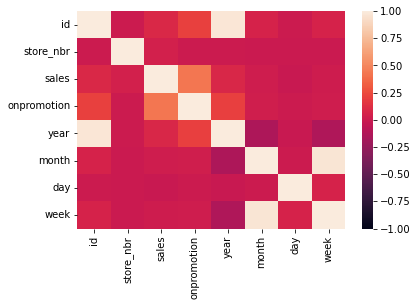

In [56]:
sns.heatmap(new_train.corr(), vmin=-1)

### Question
Which family (product) sales the most? 

In [57]:
new_train

,id,date,store_nbr,family,sales,onpromotion,city,year,month,day,week
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,2013,1,1,1
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito,2013,1,1,1
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito,2013,1,1,1
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,2013,1,1,1
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
7123,0.0,2014-12-25,9,POULTRY,0.0,0.0,Quito,2014,12,25,52
7124,0.0,2014-12-25,9,PREPARED FOODS,0.0,0.0,Quito,2014,12,25,52
7125,0.0,2014-12-25,9,PRODUCE,0.0,0.0,Quito,2014,12,25,52
7126,0.0,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,Quito,2014,12,25,52


In [58]:
new_train.shape

(3008016, 11)

In [59]:
# Grouping transactions based on the year.
family_sales = pd.DataFrame(new_train.groupby('family')['sales'].sum().sort_values(ascending = False).reset_index().head(10))
family_sales['sales'] = family_sales['sales'].apply(lambda x: math.ceil(x))
family_sales

,family,sales
0,GROCERY I,343462735
1,BEVERAGES,216954486
2,PRODUCE,122704685
3,CLEANING,97521289
4,DAIRY,64487709
5,BREAD/BAKERY,42133946
6,POULTRY,31876005
7,MEATS,31086469
8,PERSONAL CARE,24592051
9,DELI,24110323


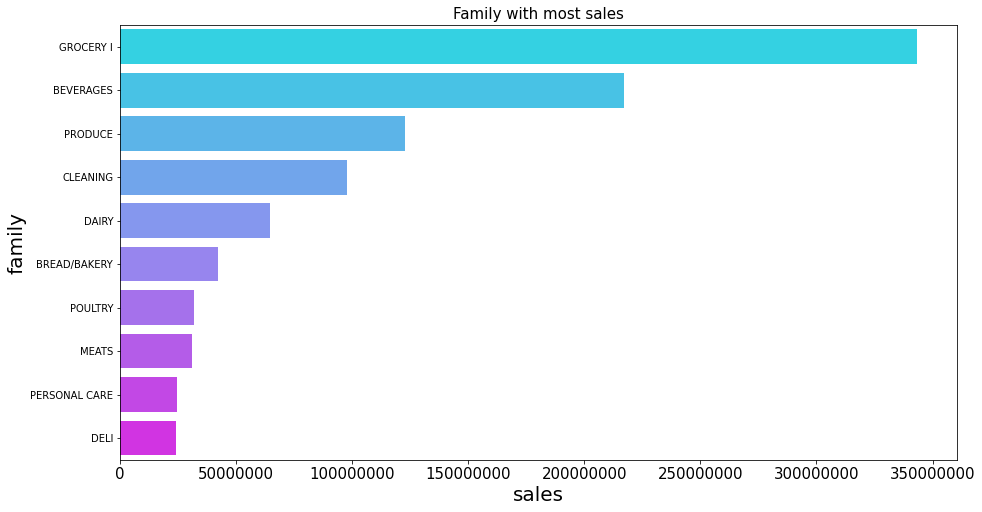

In [60]:
plt.figure(figsize = (15,8))
plt.title('Family with most sales',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('sales',fontsize = 20)
plt.xlabel('Family', fontsize = 20)
sns.barplot(x = 'sales', y = 'family', data  = family_sales,palette = 'cool')
plt.savefig('family_sales.png', dpi = 300)
plt.show()

### PROCESSING THE HOLIDAY DATA

The holiday dataset contains data about national and local that were observed. 

The tranferred column is filled 'True' or 'False'. True suggests the holiday was transferred and vise versa, A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Since transferred holidays are the same as normal days, those days will be taken out and the days that they were transferred to will be taken as the day of the holiday. The transferred holiday is a normal day and thus does not affect sales in any unique way.

In [61]:
# viewing the holiday dataset
holiday

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [62]:
holiday.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [63]:
# Viewing the dataset info
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [64]:
# Converting data type of the date column into 'datetime'.
holiday['date'] = pd.to_datetime(holiday['date'])

In [65]:
# Extracting all transferred holidays
transfer_true = holiday.loc[holiday['transferred'] != False]
transfer_true.shape

(12, 6)

In [66]:
# Viewing all holidays
holidays_not_transferred = holiday.loc[holiday['transferred'] != True]
holidays_not_transferred

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [67]:
date_list = new_train['date'].unique()

In [68]:
holidayTrain_data = pd.DataFrame(
    {
        'date': date_list,
        'holiday': [holiday.get(str(date)) for date in date_list]
    }
)

In [69]:
holidayTrain_data

,date,holiday
0,2013-01-01,None
1,2013-01-02,None
2,2013-01-03,None
3,2013-01-04,None
4,2013-01-05,None
...,...,...
1683,2017-08-15,None
1684,2016-12-25,None
1685,2015-12-25,None
1686,2013-12-25,None


In [70]:
holidayTrain_data['date'] = pd.to_datetime(holidayTrain_data['date'])
holidays_not_transferred['date'] = pd.to_datetime(holidays_not_transferred['date'])

C:\Users\Bernard Ampomah\AppData\Local\Temp\ipykernel_14356\3223433128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_not_transferred['date'] = pd.to_datetime(holidays_not_transferred['date'])


In [71]:
holidayTrain_merged = pd.merge(
    holidayTrain_data,
    holidays_not_transferred,
    how='left',
    on='date'
)

holidayTrain_merged

,date,holiday,type,locale,locale_name,description,transferred
0,2013-01-01,None,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-02,None,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,None,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,None,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,None,Work Day,National,Ecuador,Recupero puente Navidad,False
...,...,...,...,...,...,...,...
1713,2017-08-15,None,Holiday,Local,Riobamba,Fundacion de Riobamba,False
1714,2016-12-25,None,Holiday,National,Ecuador,Navidad,False
1715,2015-12-25,None,Holiday,National,Ecuador,Navidad,False
1716,2013-12-25,None,Holiday,National,Ecuador,Navidad,False


In [72]:
holidayTrain_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1718 entries, 0 to 1717
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1718 non-null   datetime64[ns]
 1   holiday      0 non-null      object        
 2   type         277 non-null    object        
 3   locale       277 non-null    object        
 4   locale_name  277 non-null    object        
 5   description  277 non-null    object        
 6   transferred  277 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 107.4+ KB


In [73]:
holidayTrain_merged.replace(np.NAN, value = 'None', inplace = True)
holidayTrain_merged

,date,holiday,type,locale,locale_name,description,transferred
0,2013-01-01,None,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-02,None,None,None,None,None,None
2,2013-01-03,None,None,None,None,None,None
3,2013-01-04,None,None,None,None,None,None
4,2013-01-05,None,Work Day,National,Ecuador,Recupero puente Navidad,False
...,...,...,...,...,...,...,...
1713,2017-08-15,None,Holiday,Local,Riobamba,Fundacion de Riobamba,False
1714,2016-12-25,None,Holiday,National,Ecuador,Navidad,False
1715,2015-12-25,None,Holiday,National,Ecuador,Navidad,False
1716,2013-12-25,None,Holiday,National,Ecuador,Navidad,False


In [74]:
NewTrain = pd.merge(
    new_train,
    holidayTrain_merged.drop(columns = ['holiday', 'locale_name','transferred']),
    how='left',
    on='date'
)

NewTrain

,id,date,store_nbr,family,sales,onpromotion,city,year,month,day,week,type,locale,description
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061471,0.0,2014-12-25,9,POULTRY,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad
3061472,0.0,2014-12-25,9,PREPARED FOODS,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad
3061473,0.0,2014-12-25,9,PRODUCE,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad
3061474,0.0,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad


In [75]:
NewTrain['is_holiday'] = np.where(NewTrain['type'] == 'None', 0, 1)

In [76]:
NewTrain.type.unique()

array(['Holiday', 'None', 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

In [77]:
NewHoliday = NewTrain.loc[NewTrain ['is_holiday']!= 0]
NewHoliday.shape

(493614, 15)

### Question
Which type of holiday brings about more sales.?

In [78]:
holiday_sales = pd.DataFrame(NewHoliday.groupby('type')['sales'].sum().sort_values(ascending = False).reset_index().head(10))
holiday_sales['sales'] = holiday_sales['sales'].apply(lambda x: math.ceil(x))
holiday_sales

,type,sales
0,Holiday,104225865
1,Event,42477470
2,Additional,33020281
3,Transfer,7501825
4,Work Day,3315924
5,Bridge,2388331


In [79]:
locale_sales = pd.DataFrame(NewHoliday.groupby('locale')['sales'].sum().sort_values(ascending = False).reset_index().head(10))
locale_sales['sales'] = locale_sales['sales'].apply(lambda x: math.ceil(x))
locale_sales

,locale,sales
0,National,105661953
1,Local,74854143
2,Regional,12413598


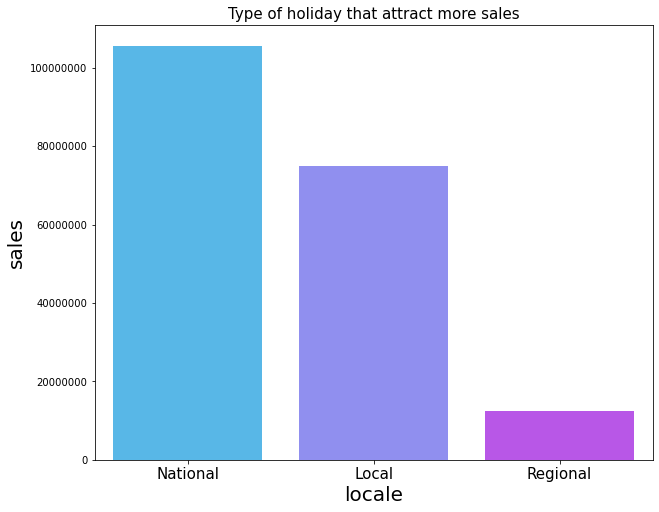

In [80]:
plt.figure(figsize = (10,8))
plt.title('Type of holiday that attract more sales',fontsize = 15)
plt.ticklabel_format(style = 'plain')
plt.xticks(fontsize = 15, rotation = 'horizontal')
plt.ylabel('locale',fontsize = 20)
plt.xlabel('sales', fontsize = 20)
sns.barplot(x = 'locale', y = 'sales', data  = locale_sales,palette = 'cool')
plt.savefig('locale_sales.png', dpi = 300)
plt.show()

In [81]:
# Extracting the sum of all sales for holidays and ordinary days.
Holiday_NonHolidaySales = pd.DataFrame(NewTrain.groupby('is_holiday')['sales'].sum().sort_values(ascending = False).reset_index().head(10))
Holiday_NonHolidaySales

,is_holiday,sales
0,0,9.036451e+08
1,1,1.929297e+08


In [82]:
# Extracting max sales for holidays and normal or ordinary days.
Holiday_NonHolidaySales = pd.DataFrame(NewTrain.groupby('is_holiday')['sales'].max().sort_values(ascending = False).reset_index().head(10))
Holiday_NonHolidaySales

,is_holiday,sales
0,1,124717.00
1,0,40351.46


##### Comment
From the immediate 2 tables above, we can see that the sum of sales on normal days out weighs that on the sales on holidays. This is expected because the number of normal days are far greater than the days of holidays. 

However we see a different story when the max sales on holidays and normal days are extracted. The max sales on holidays are huge than the sales on ordinary days which are not holidays. This clearly shows that holidays have positive impact on sales. Customers buy more on holidays.

### PROCESSING THE OIL DATA SET.
The oil data contains the changes in the oil prices within the year of review (2013 - 2017)

In [83]:
# Viewing the oil data.
oil.head

<bound method NDFrame.head of             date  dcoilwtico
0     2013-01-01         NaN
1     2013-01-02       93.14
2     2013-01-03       92.97
3     2013-01-04       93.12
4     2013-01-07       93.20
...          ...         ...
1213  2017-08-25       47.65
1214  2017-08-28       46.40
1215  2017-08-29       46.46
1216  2017-08-30       45.96
1217  2017-08-31       47.26

[1218 rows x 2 columns]>

In [84]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [85]:
# Checking for null values in the oil dataset.
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [86]:
# Viewing of null values in the oil dataset.
oil[oil['dcoilwtico'].isna()]

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


In [87]:
# Filling null values in the oil dataset with previous values.
oil = oil.ffill().bfill()
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [88]:
oil.dcoilwtico.nunique()

998

In [89]:
# Converting the 'date' column into a datetime format and setting it as the index.
oil['date'] = pd.to_datetime(oil['date']).dt.date

In [90]:
oilTrain_data = pd.DataFrame(
    {
        'date': date_list,
        'oilPrice': [oil.get(str(date)) for date in date_list]
    }
)

In [91]:
oilTrain_data

,date,oilPrice
0,2013-01-01,None
1,2013-01-02,None
2,2013-01-03,None
3,2013-01-04,None
4,2013-01-05,None
...,...,...
1683,2017-08-15,None
1684,2016-12-25,None
1685,2015-12-25,None
1686,2013-12-25,None


In [92]:
oilTrain_data['date'] = pd.to_datetime(oilTrain_data['date']).dt.date

In [93]:
oilTrain_merged = pd.merge(
    oilTrain_data.drop(columns = ['oilPrice']),
    oil,
    how='left',
    on='date'
)

In [94]:
oilTrain_merged

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN
...,...,...
1683,2017-08-15,47.57
1684,2016-12-25,NaN
1685,2015-12-25,37.62
1686,2013-12-25,98.87


In [95]:
oilTrain_merged['date'] = pd.to_datetime(oilTrain_merged['date']).dt.date

In [96]:
NewTrain['date'] = pd.to_datetime(NewTrain['date']).dt.date

In [97]:
oilTrain_merged.dcoilwtico.isnull().sum()

482

In [98]:
oilTrain_merged = oilTrain_merged.ffill().bfill()
oilTrain_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 0 to 1687
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1688 non-null   object 
 1   dcoilwtico  1688 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.6+ KB


In [99]:
oilTrain_merged.rename(columns = {'dcoilwtico':'oil_price'}, inplace = True)
oilTrain_merged

,date,oil_price
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12
...,...,...
1683,2017-08-15,47.57
1684,2016-12-25,47.57
1685,2015-12-25,37.62
1686,2013-12-25,98.87


In [100]:
NewTrain = pd.merge(
    NewTrain,
    oilTrain_merged,
    how='left',
    on='date'
)
NewTrain

,id,date,store_nbr,family,sales,onpromotion,city,year,month,day,week,type,locale,description,is_holiday,oil_price
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061471,0.0,2014-12-25,9,POULTRY,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad,1,55.70
3061472,0.0,2014-12-25,9,PREPARED FOODS,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad,1,55.70
3061473,0.0,2014-12-25,9,PRODUCE,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad,1,55.70
3061474,0.0,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad,1,55.70


### Question
What is the impact of oil prices on sales?

In [101]:
sales_oil = pd.DataFrame(NewTrain.groupby('sales')['oil_price'].sum().sort_values(ascending = False).reset_index())
sales_oil['oil_price'] = sales_oil['oil_price'].apply(lambda x: math.ceil(x))
sales_oil

,sales,oil_price
0,0.000,74303616
1,1.000,7483805
2,2.000,5568997
3,3.000,4405863
4,4.000,3676136
...,...,...
379605,534.552,27
379606,581.821,27
379607,390.143,27
379608,536.143,27


##### Comment
From the table above it can be seen that when oil prices are go up or when oil prices are high, sales is low and vise versa. This shows that theres an inverse relationship between the oil prices and sales. This shows that the impact of oil prices on sales is negative when oil prices go up.

## FEATURE ENGINEERING

In [102]:
def getSeason (row):
    if row in (3, 4, 5):
        return 'Spring'
    elif row in (6, 7, 8): 
        return 'Summer'
    elif row in (9, 10, 11): 
        return 'Autumnf'
    elif row in (12, 1, 2):
        return 'Winter'

def getDateFeatures (NewTrain_data, date):
    NewTrain_data ['date'] = pd.to_datetime(NewTrain_data['date'])
    NewTrain_data ['month'] = NewTrain_data ['date'].dt.month
    NewTrain_data ['day_of_month'] = NewTrain_data ['date'].dt.day 
    NewTrain_data ['day_of_year'] = NewTrain_data['date'].dt.dayofyear
    NewTrain_data ['week_of_year'] = NewTrain_data ['date'].dt.isocalendar().week 
    NewTrain_data ['day_of_week'] = NewTrain_data ['date'].dt.dayofweek
    NewTrain_data ['year'] = NewTrain_data['date'].dt.year
    NewTrain_data ["is_weekend"] = np.where(NewTrain_data ['day_of_week'] > 4, 1, 0)
    NewTrain_data ['is_month_start'] = NewTrain_data ['date'].dt.is_month_start.astype(int) 
    NewTrain_data ['is_month_end'] = NewTrain_data ['date'].dt.is_month_end.astype (int)
    NewTrain_data ['quarter'] = NewTrain_data ['date'].dt.quarter
    NewTrain_data ['is_quarter_start'] = NewTrain_data ['date'].dt.is_quarter_start.astype(int)
    NewTrain_data ['is_quarter_end'] = NewTrain_data['date'].dt.is_quarter_end.astype(int)
    NewTrain_data ['is_year_start'] = NewTrain_data['date'].dt.is_year_start.astype(int)
    NewTrain_data ['is_year_end'] = NewTrain_data['date'].dt.is_year_end.astype (int) 
    NewTrain_data ['season'] = NewTrain_data ['month'].apply(getSeason)

    return NewTrain_data

In [103]:
NewTrain_data = getDateFeatures(NewTrain, 'date')

In [104]:
NewTrain_data

,id,date,store_nbr,family,sales,onpromotion,city,year,month,day,...,day_of_week,is_weekend,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,2013,1,1,...,1,0,1,0,1,1,0,1,0,Winter
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito,2013,1,1,...,1,0,1,0,1,1,0,1,0,Winter
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito,2013,1,1,...,1,0,1,0,1,1,0,1,0,Winter
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,2013,1,1,...,1,0,1,0,1,1,0,1,0,Winter
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito,2013,1,1,...,1,0,1,0,1,1,0,1,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061471,0.0,2014-12-25,9,POULTRY,0.0,0.0,Quito,2014,12,25,...,3,0,0,0,4,0,0,0,0,Winter
3061472,0.0,2014-12-25,9,PREPARED FOODS,0.0,0.0,Quito,2014,12,25,...,3,0,0,0,4,0,0,0,0,Winter
3061473,0.0,2014-12-25,9,PRODUCE,0.0,0.0,Quito,2014,12,25,...,3,0,0,0,4,0,0,0,0,Winter
3061474,0.0,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,Quito,2014,12,25,...,3,0,0,0,4,0,0,0,0,Winter


In [105]:
pd.set_option('display.max_columns', None)
NewTrain_data

,id,date,store_nbr,family,sales,onpromotion,city,year,month,day,week,type,locale,description,is_holiday,oil_price,day_of_month,day_of_year,week_of_year,day_of_week,is_weekend,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,Winter
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,Winter
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,Winter
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,Winter
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,Quito,2013,1,1,1,Holiday,National,Primer dia del ano,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061471,0.0,2014-12-25,9,POULTRY,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad,1,55.70,25,359,52,3,0,0,0,4,0,0,0,0,Winter
3061472,0.0,2014-12-25,9,PREPARED FOODS,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad,1,55.70,25,359,52,3,0,0,0,4,0,0,0,0,Winter
3061473,0.0,2014-12-25,9,PRODUCE,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad,1,55.70,25,359,52,3,0,0,0,4,0,0,0,0,Winter
3061474,0.0,2014-12-25,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,Quito,2014,12,25,52,Holiday,National,Navidad,1,55.70,25,359,52,3,0,0,0,4,0,0,0,0,Winter


In [106]:
NewTrain_data = NewTrain_data.drop(columns = ['day', 'week', 'month'])

In [107]:
NewTrain_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3061476 entries, 0 to 3061475
Data columns (total 26 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                float64       
 1   date              datetime64[ns]
 2   store_nbr         int64         
 3   family            object        
 4   sales             float64       
 5   onpromotion       float64       
 6   city              object        
 7   year              int64         
 8   type              object        
 9   locale            object        
 10  description       object        
 11  is_holiday        int32         
 12  oil_price         float64       
 13  day_of_month      int64         
 14  day_of_year       int64         
 15  week_of_year      UInt32        
 16  day_of_week       int64         
 17  is_weekend        int32         
 18  is_month_start    int32         
 19  is_month_end      int32         
 20  quarter           int64         
 21  is_quart

## ENCODING DATA
Encoding is simply assigning numerical values to text. Since this is a machine learning project all columns with text must be encoded before training a model.

In [108]:
from sklearn.preprocessing import LabelEncoder

In [109]:
# Encoding all columns with text to numerical values (TRAIN DATA)
data_encoder = LabelEncoder()
NewTrain_data['season'] = data_encoder.fit_transform(NewTrain_data['season'])
NewTrain_data['family'] = data_encoder.fit_transform(NewTrain_data['family'])
NewTrain_data['city'] = data_encoder.fit_transform(NewTrain_data['city'])
NewTrain_data['type'] = data_encoder.fit_transform(NewTrain_data['type'])
NewTrain_data['locale'] = data_encoder.fit_transform(NewTrain_data['locale'])
NewTrain_data['description'] = data_encoder.fit_transform(NewTrain_data['description'])

In [110]:
NewTrain_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,year,type,locale,description,is_holiday,oil_price,day_of_month,day_of_year,week_of_year,day_of_week,is_weekend,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
0,0.0,2013-01-01,1,0,0.0,0.0,18,2013,3,1,52,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,3
1,1.0,2013-01-01,1,1,0.0,0.0,18,2013,3,1,52,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,3
2,2.0,2013-01-01,1,2,0.0,0.0,18,2013,3,1,52,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,3
3,3.0,2013-01-01,1,3,0.0,0.0,18,2013,3,1,52,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,3
4,4.0,2013-01-01,1,4,0.0,0.0,18,2013,3,1,52,1,93.14,1,1,1,1,0,1,0,1,1,0,1,0,3


In [111]:
# NewTrain_data = NewTrain_data.drop(columns = ['date'])

In [112]:
NewTrain_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3061476 entries, 0 to 3061475
Data columns (total 26 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                float64       
 1   date              datetime64[ns]
 2   store_nbr         int64         
 3   family            int32         
 4   sales             float64       
 5   onpromotion       float64       
 6   city              int32         
 7   year              int64         
 8   type              int32         
 9   locale            int32         
 10  description       int32         
 11  is_holiday        int32         
 12  oil_price         float64       
 13  day_of_month      int64         
 14  day_of_year       int64         
 15  week_of_year      UInt32        
 16  day_of_week       int64         
 17  is_weekend        int32         
 18  is_month_start    int32         
 19  is_month_end      int32         
 20  quarter           int64         
 21  is_quart

Splitting the data in two as train and test data sets

In [113]:
split_date1 = pd.to_datetime('2017-01-1')

Train = NewTrain_data.loc[NewTrain_data['date'] <= split_date1]
Test = NewTrain_data.loc[NewTrain_data['date'] > split_date1]
print('Train :',Train.shape)
print('Test :',Test.shape)

Train : (2651616, 26)
Test : (409860, 26)


In [114]:
# Test.year.unique(), Test.month.unique()

In [115]:
# Train.year.unique(), Train.month.unique()

In [116]:
Train = Train.drop(columns = ['date'])

In [117]:
Test = Test.drop(columns = ['date'])

#### TRAINING A MODEL USING DECISION TREE REGRESSION.

In [118]:
# Importing libraries for training the model.

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [119]:
# Creating an instance for the model.
Decision_tree_model = DecisionTreeRegressor(random_state=167)

In [120]:
x_train = Train.drop(columns=['sales'])
y_train = Train['sales']

In [121]:
# Training the model
Decision_tree_model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=167)

In [122]:
x_test = Test.drop(columns=['sales'])
y_test = Test['sales']

In [123]:
y_pred = Decision_tree_model.predict(x_test)

#### Evaluating the Decision Tree model

In [124]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [125]:
mean_absolute_error(y_test, y_pred)

159.47420823251966

In [126]:
np.sqrt(mean_squared_error(y_test, y_pred))

839.071603144897

In [127]:
mean_squared_log_error(y_test, y_pred)

1.2650898285399947

#### TRAINING THE MODEL WITH LINEAR REGRESSION

In [128]:
linear_model = LinearRegression()

In [129]:
linear_model.fit(x_train, y_train)

LinearRegression()

In [130]:
y_pred = linear_model.predict(x_test)

#### Evaluating the Lenear Regression Model

In [131]:
mean_absolute_error(y_test, y_pred)

474.7042122607356

In [133]:
np.sqrt(mean_squared_error(y_test, y_pred))

1106.721556014437

In [ ]:
mean_squared_log_error(y_test, y_pred)

#### TRAINING THE MODEL WITH RANDOM FOREST

In [ ]:
random_forest_model = RandomForestRgressor()

In [ ]:
random_forest_model.fit(x_train, y_train)

In [ ]:
y_pred = random_forest_model.predict(x_train)

#### Evaluating the Lenear Regression Model

In [ ]:
mean_absolute_error(y_test, y)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
mean_squared_log_error(y_test, y_pred)

### PROCESSING THE TEST DATA SET

In [134]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [135]:
split_date1 = pd.to_datetime('2017-08-15')

oil_Train = oil.loc[oil['date'] <= split_date1]
oil_test = oil.loc[oil['date'] > split_date1]
print('Train :',oil_Train.shape)
print('Test :',oil_test.shape)

Train : (1206, 2)
Test : (12, 2)


C:\Users\Bernard Ampomah\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [136]:
oil_test

,date,dcoilwtico
1206,2017-08-16,46.80
1207,2017-08-17,47.07
1208,2017-08-18,48.59
1209,2017-08-21,47.39
1210,2017-08-22,47.65
1211,2017-08-23,48.45
1212,2017-08-24,47.24
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46


In [137]:
date_list2 = test['date'].unique()

In [138]:
oilTest_data = pd.DataFrame(
    {
        'date': date_list2,
        'oilPrice': [oil.get(str(date)) for date in date_list2]
    }
)

In [139]:
oilTest_data

,date,oilPrice
0,2017-08-16,None
1,2017-08-17,None
2,2017-08-18,None
3,2017-08-19,None
4,2017-08-20,None
5,2017-08-21,None
6,2017-08-22,None
7,2017-08-23,None
8,2017-08-24,None
9,2017-08-25,None


In [140]:
oilTest_data['date'] = pd.to_datetime(oilTest_data['date']).dt.date

In [141]:
oil_test['date'] = pd.to_datetime(oil_test['date']).dt.date

C:\Users\Bernard Ampomah\AppData\Local\Temp\ipykernel_14356\2957453761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_test['date'] = pd.to_datetime(oil_test['date']).dt.date


In [142]:
oiltest_merged = pd.merge(
    oilTest_data.drop(columns = ['oilPrice']),
    oil_test,
    how='left',
    on='date'
)

In [143]:
oiltest_merged

,date,dcoilwtico
0,2017-08-16,46.80
1,2017-08-17,47.07
2,2017-08-18,48.59
3,2017-08-19,NaN
4,2017-08-20,NaN
5,2017-08-21,47.39
6,2017-08-22,47.65
7,2017-08-23,48.45
8,2017-08-24,47.24
9,2017-08-25,47.65


In [144]:
oiltest_merged = oiltest_merged.ffill().bfill()
oiltest_merged

,date,dcoilwtico
0,2017-08-16,46.80
1,2017-08-17,47.07
2,2017-08-18,48.59
3,2017-08-19,48.59
4,2017-08-20,48.59
5,2017-08-21,47.39
6,2017-08-22,47.65
7,2017-08-23,48.45
8,2017-08-24,47.24
9,2017-08-25,47.65


In [145]:
oiltest_merged.rename(columns = {'dcoilwtico':'oil_price'}, inplace = True)
oiltest_merged

,date,oil_price
0,2017-08-16,46.80
1,2017-08-17,47.07
2,2017-08-18,48.59
3,2017-08-19,48.59
4,2017-08-20,48.59
5,2017-08-21,47.39
6,2017-08-22,47.65
7,2017-08-23,48.45
8,2017-08-24,47.24
9,2017-08-25,47.65


In [146]:
test['date'] = pd.to_datetime(test['date']).dt.date
oiltest_merged['date'] = pd.to_datetime(oiltest_merged['date']).dt.date

In [147]:
NewTest = pd.merge(
    test,
    oiltest_merged,
    how='left',
    on='date'
)
NewTest

,id,date,store_nbr,family,onpromotion,oil_price
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.80
1,3000889,2017-08-16,1,BABY CARE,0,46.80
2,3000890,2017-08-16,1,BEAUTY,2,46.80
3,3000891,2017-08-16,1,BEVERAGES,20,46.80
4,3000892,2017-08-16,1,BOOKS,0,46.80
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,47.26
28508,3029396,2017-08-31,9,PREPARED FOODS,0,47.26
28509,3029397,2017-08-31,9,PRODUCE,1,47.26
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26


In [148]:
NewTest.oil_price.unique()

array([46.8 , 47.07, 48.59, 47.39, 47.65, 48.45, 47.24, 46.4 , 46.46,
       45.96, 47.26])

###### Processing holiday data for test data

In [149]:
holiday

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [150]:
holiday['date'] = pd.to_datetime(holiday['date']).dt.date

In [151]:
split_date2 = pd.to_datetime('2017-08-15')

holidayTrain = holiday.loc[holiday['date'] <= split_date2]
holidayTest = holiday.loc[holiday['date'] > split_date2]
print('Train :',holidayTrain.shape)
print('Test :',holidayTest.shape)

Train : (327, 6)
Test : (23, 6)


C:\Users\Bernard Ampomah\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [152]:
holidayTest

,date,type,locale,locale_name,description,transferred
327,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False
328,2017-09-28,Holiday,Local,Ibarra,Fundacion de Ibarra,True
329,2017-09-29,Transfer,Local,Ibarra,Fundacion de Ibarra,False
330,2017-10-07,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False
331,2017-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
332,2017-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
333,2017-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
334,2017-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False
335,2017-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
336,2017-11-10,Holiday,Local,Guaranda,Independencia de Guaranda,False


In [153]:
holidayTest_data = pd.DataFrame(
    {
        'date': date_list2,
        'holiday': [holiday.get(str(date)) for date in date_list2]
    }
)
holidayTest_data

,date,holiday
0,2017-08-16,None
1,2017-08-17,None
2,2017-08-18,None
3,2017-08-19,None
4,2017-08-20,None
5,2017-08-21,None
6,2017-08-22,None
7,2017-08-23,None
8,2017-08-24,None
9,2017-08-25,None


In [154]:
holidayTest['date'] = pd.to_datetime(holidayTest['date']).dt.date
holidayTest_data['date'] = pd.to_datetime(holidayTest_data['date']).dt.date

C:\Users\Bernard Ampomah\AppData\Local\Temp\ipykernel_14356\1079649523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidayTest['date'] = pd.to_datetime(holidayTest['date']).dt.date


In [155]:
holidayTest_merged = pd.merge(
    holidayTest_data.drop(columns = ['holiday']),
    holidayTest,
    how='left',
    on='date'
)

holidayTest_merged

,date,type,locale,locale_name,description,transferred
0,2017-08-16,NaN,NaN,NaN,NaN,NaN
1,2017-08-17,NaN,NaN,NaN,NaN,NaN
2,2017-08-18,NaN,NaN,NaN,NaN,NaN
3,2017-08-19,NaN,NaN,NaN,NaN,NaN
4,2017-08-20,NaN,NaN,NaN,NaN,NaN
5,2017-08-21,NaN,NaN,NaN,NaN,NaN
6,2017-08-22,NaN,NaN,NaN,NaN,NaN
7,2017-08-23,NaN,NaN,NaN,NaN,NaN
8,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False
9,2017-08-25,NaN,NaN,NaN,NaN,NaN


In [156]:
# Merging to original test data set
NewTest = pd.merge(
    NewTest,
    holidayTest_merged.drop(columns = ['locale_name', 'transferred']),
    how='left',
    on='date'
)
NewTest

,id,date,store_nbr,family,onpromotion,oil_price,type,locale,description
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.80,NaN,NaN,NaN
1,3000889,2017-08-16,1,BABY CARE,0,46.80,NaN,NaN,NaN
2,3000890,2017-08-16,1,BEAUTY,2,46.80,NaN,NaN,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,46.80,NaN,NaN,NaN
4,3000892,2017-08-16,1,BOOKS,0,46.80,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,47.26,NaN,NaN,NaN
28508,3029396,2017-08-31,9,PREPARED FOODS,0,47.26,NaN,NaN,NaN
28509,3029397,2017-08-31,9,PRODUCE,1,47.26,NaN,NaN,NaN
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26,NaN,NaN,NaN


In [157]:
NewTest.replace(np.NAN, value = 'None', inplace = True)
NewTest

,id,date,store_nbr,family,onpromotion,oil_price,type,locale,description
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.80,None,None,None
1,3000889,2017-08-16,1,BABY CARE,0,46.80,None,None,None
2,3000890,2017-08-16,1,BEAUTY,2,46.80,None,None,None
3,3000891,2017-08-16,1,BEVERAGES,20,46.80,None,None,None
4,3000892,2017-08-16,1,BOOKS,0,46.80,None,None,None
...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,47.26,None,None,None
28508,3029396,2017-08-31,9,PREPARED FOODS,0,47.26,None,None,None
28509,3029397,2017-08-31,9,PRODUCE,1,47.26,None,None,None
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26,None,None,None


In [158]:
NewTest['is_holiday'] = np.where(NewTest['type'] == 'None', 0, 1)


In [159]:
NewTest['city'] = np.nan
NewTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           28512 non-null  int64  
 1   date         28512 non-null  object 
 2   store_nbr    28512 non-null  int64  
 3   family       28512 non-null  object 
 4   onpromotion  28512 non-null  int64  
 5   oil_price    28512 non-null  float64
 6   type         28512 non-null  object 
 7   locale       28512 non-null  object 
 8   description  28512 non-null  object 
 9   is_holiday   28512 non-null  int32  
 10  city         0 non-null      float64
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 2.5+ MB


In [160]:
NewTest['city'] = NewTest['store_nbr'].map({1:'Quito', 2:'Quito', 3:'Quito', 4:'Quito', 6:'Quito', 7:'Quito', 8:'Quito',
                                                9:'Quito', 10:'Quito', 17:'Quito', 18:'Quito', 20:'Quito', 44:'Quito', 45:'Quito',
                                               46:'Quito', 46:'Quito', 47:'Quito', 48:'Quito', 49:'Quito', 5:'Santo Domingo', 16:'Santo Domingo',
                                               21:'Santo Domingo', 11:'Cayambe', 12:'Latacunga', 13:'Latacunga', 14:'Riobamba',
                                               15:'Ibarra', 19:'Guaranda', 22:'Puyo', 23:'Ambato', 50:'Ambato', 24:'Guayaquil',
                                               26:'Guayaquil', 28:'Guayaquil', 29:'Guayaquil', 30:'Guayaquil', 32:'Guayaquil',
                                               34:'Guayaquil', 51:'Guayaquil', 25:'Salinas', 27:'Daule', 31:'Babahoyo', 33:'Quevedo',
                                               35:'Playas', 36:'Libertad', 37:'Cuenca', 39:'Cuenca', 42:'Cuenca', 38:'Loja',
                                               40:'Machala', 41:'Machala', 43:'Esmeraldas', 52:'Manta', 53:'Manta', 54:'El Carmen'})

NewTest.head()

,id,date,store_nbr,family,onpromotion,oil_price,type,locale,description,is_holiday,city
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,None,None,None,0,Quito
1,3000889,2017-08-16,1,BABY CARE,0,46.8,None,None,None,0,Quito
2,3000890,2017-08-16,1,BEAUTY,2,46.8,None,None,None,0,Quito
3,3000891,2017-08-16,1,BEVERAGES,20,46.8,None,None,None,0,Quito
4,3000892,2017-08-16,1,BOOKS,0,46.8,None,None,None,0,Quito


#### Feature Engineering

In [161]:
NewTest = getDateFeatures(NewTest, 'date')
NewTest

,id,date,store_nbr,family,onpromotion,oil_price,type,locale,description,is_holiday,city,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.80,None,None,None,0,Quito,8,16,228,33,2,2017,0,0,0,3,0,0,0,0,Summer
1,3000889,2017-08-16,1,BABY CARE,0,46.80,None,None,None,0,Quito,8,16,228,33,2,2017,0,0,0,3,0,0,0,0,Summer
2,3000890,2017-08-16,1,BEAUTY,2,46.80,None,None,None,0,Quito,8,16,228,33,2,2017,0,0,0,3,0,0,0,0,Summer
3,3000891,2017-08-16,1,BEVERAGES,20,46.80,None,None,None,0,Quito,8,16,228,33,2,2017,0,0,0,3,0,0,0,0,Summer
4,3000892,2017-08-16,1,BOOKS,0,46.80,None,None,None,0,Quito,8,16,228,33,2,2017,0,0,0,3,0,0,0,0,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,47.26,None,None,None,0,Quito,8,31,243,35,3,2017,0,0,1,3,0,0,0,0,Summer
28508,3029396,2017-08-31,9,PREPARED FOODS,0,47.26,None,None,None,0,Quito,8,31,243,35,3,2017,0,0,1,3,0,0,0,0,Summer
28509,3029397,2017-08-31,9,PRODUCE,1,47.26,None,None,None,0,Quito,8,31,243,35,3,2017,0,0,1,3,0,0,0,0,Summer
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26,None,None,None,0,Quito,8,31,243,35,3,2017,0,0,1,3,0,0,0,0,Summer


#### Encoding

In [162]:
# Encoding all columns with text to numerical values (TEST DATA)
data_encoder = LabelEncoder()
NewTest['season'] = data_encoder.fit_transform(NewTest['season'])
NewTest['family'] = data_encoder.fit_transform(NewTest['family'])
NewTest['city'] = data_encoder.fit_transform(NewTest['city'])
NewTest['type'] = data_encoder.fit_transform(NewTest['type'])
NewTest['locale'] = data_encoder.fit_transform(NewTest['locale'])
NewTest['description'] = data_encoder.fit_transform(NewTest['description'])

#### TRAINING A MODEL

In [163]:
NewTest = NewTest.drop(columns = ['date'])

In [164]:
# Creating an instance for the model.
Decision_tree_model = DecisionTreeRegressor(random_state=150)

In [165]:
submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [181]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409860 entries, 2644488 to 3054347
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                409860 non-null  float64
 1   store_nbr         409860 non-null  int64  
 2   family            409860 non-null  int32  
 3   sales             409860 non-null  float64
 4   onpromotion       409860 non-null  float64
 5   city              409860 non-null  int32  
 6   year              409860 non-null  int64  
 7   type              409860 non-null  int32  
 8   locale            409860 non-null  int32  
 9   description       409860 non-null  int32  
 10  is_holiday        409860 non-null  int32  
 11  oil_price         409860 non-null  float64
 12  day_of_month      409860 non-null  int64  
 13  day_of_year       409860 non-null  int64  
 14  week_of_year      409860 non-null  UInt32 
 15  day_of_week       409860 non-null  int64  
 16  is_weekend   

In [182]:
NewTest = NewTest.drop(columns = ['month'])

In [189]:
NewTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                28512 non-null  int64  
 1   store_nbr         28512 non-null  int64  
 2   family            28512 non-null  int32  
 3   onpromotion       28512 non-null  int64  
 4   oil_price         28512 non-null  float64
 5   type              28512 non-null  int32  
 6   locale            28512 non-null  int32  
 7   description       28512 non-null  int32  
 8   is_holiday        28512 non-null  int32  
 9   city              28512 non-null  int32  
 10  day_of_month      28512 non-null  int64  
 11  day_of_year       28512 non-null  int64  
 12  week_of_year      28512 non-null  UInt32 
 13  day_of_week       28512 non-null  int64  
 14  year              28512 non-null  int64  
 15  is_weekend        28512 non-null  int32  
 16  is_month_start    28512 non-null  int32 

In [183]:
predictions = Decision_tree_model.predict(NewTest) 

C:\Users\Bernard Ampomah\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [186]:
predictions


array([  10.   ,    0.   ,    9.   , ..., 1369.5  ,   56.191,    0.   ])

In [187]:
predictions = pd.DataFrame(predictions, columns = ['sales'])

In [188]:
predictions

,sales
0,10.000
1,0.000
2,9.000
3,2281.000
4,0.000
...,...
28507,259.306
28508,99.420
28509,1369.500
28510,56.191


In [194]:
Pred_Test = pd.merge(
    NewTest,
    predictions,
    left_index=True,
    right_index=True

)
Pred_Test

,id,store_nbr,family,onpromotion,oil_price,type,locale,description,is_holiday,city,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,sales
0,3000888,1,0,0,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,10.000
1,3000889,1,1,0,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,0.000
2,3000890,1,2,2,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,9.000
3,3000891,1,3,20,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,2281.000
4,3000892,1,4,0,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,9,28,1,47.26,1,1,1,0,18,31,243,35,3,2017,0,0,1,3,0,0,0,0,0,259.306
28508,3029396,9,29,0,47.26,1,1,1,0,18,31,243,35,3,2017,0,0,1,3,0,0,0,0,0,99.420
28509,3029397,9,30,1,47.26,1,1,1,0,18,31,243,35,3,2017,0,0,1,3,0,0,0,0,0,1369.500
28510,3029398,9,31,9,47.26,1,1,1,0,18,31,243,35,3,2017,0,0,1,3,0,0,0,0,0,56.191


In [197]:
Test_submission = Pred_Test.drop(columns = ['day_of_month', 'day_of_year', 'week_of_year', 'day_of_week', 'year',
                                 "is_weekend", 'is_month_start', 'is_month_end', 'quarter', 'is_quarter_start', 'is_quarter_end',
                                 'is_year_start', 'is_year_end','season', 'store_nbr', 'family', 'onpromotion', 
                                 'oil_price','type', 'locale', 'description', 'is_holiday', 'city'])

,id,store_nbr,family,onpromotion,oil_price,type,locale,description,is_holiday,city,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,sales
0,3000888,1,0,0,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,10.000
1,3000889,1,1,0,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,0.000
2,3000890,1,2,2,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,9.000
3,3000891,1,3,20,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,2281.000
4,3000892,1,4,0,46.80,1,1,1,0,18,16,228,33,2,2017,0,0,0,3,0,0,0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,9,28,1,47.26,1,1,1,0,18,31,243,35,3,2017,0,0,1,3,0,0,0,0,0,259.306
28508,3029396,9,29,0,47.26,1,1,1,0,18,31,243,35,3,2017,0,0,1,3,0,0,0,0,0,99.420
28509,3029397,9,30,1,47.26,1,1,1,0,18,31,243,35,3,2017,0,0,1,3,0,0,0,0,0,1369.500
28510,3029398,9,31,9,47.26,1,1,1,0,18,31,243,35,3,2017,0,0,1,3,0,0,0,0,0,56.191


In [200]:
Test_submission.to_csv('Test_submission.csv', index=False)